In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [77]:
def weight_init(experts,opening,method,tickers):
    #add market cap initialization
    if method == 'equal':
        w = np.ones(experts)
        w[opening.iloc[0]==0] = 0
        w[opening.iloc[0].isnull()] = 0
        return w
    
    elif method == 'marketcap':
        caps_dict = pd.read_csv('marketcapdata.csv', index_col='Name').to_dict()['Market Cap']
        w = []
        
        for ticker in tickers:
            try:
                w.append(caps_dict[ticker])
            except:
                w.append(0)
        w = np.array(w)
        w[opening.iloc[0]==0] = 0
        w[opening.iloc[0].isnull()] = 0
        return np.array(w).astype('float64')
    else:
        print('Invalid method')
    

def losses(opening,closing,method):
    if method == 'absolute': #absolute return (close-open)
        return -1*(closing-opening)
    
    elif method=='pricerel': #price relative #closing over opening
        try:
            return -1*(closing/opening-1)
        except:
            return 0
    elif method==3: #beta
        return 1
    
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [78]:
def mwu(filename,lossmethod,weightmethod):
    #data is a T by N matrix with each row being the returns of each expert i at time t
    data = pd.read_excel(filename)[::-1]
    opening = data.iloc[:,::2]
    closing = data.iloc[:,1::2]
    tickers = [name[:name.find('_')] for name in opening.columns]
    #print(tickers)
    #return 0
    dates = opening.index.values
    #print(dates)
    #return 0
#     returns = pd.DataFrame()
#     for i in range(len(opening.columns)):
#         tick = closing.iloc[:,i].name[:4]
#         returns[tick]=closing.iloc[:,i]-opening.iloc[:,i]
    
#     pricerel = pd.DataFrame()
#     for i in range(len(opening.columns)):
#         tick = closing.iloc[:,i].name[:4]
#         pricerel[tick]=closing.iloc[:,i]/opening.iloc[:,i]
    
    T = len(data)
    N = len(opening.columns)
    epsilon = np.sqrt(np.log(N)/T) 
   
    w = weight_init(N,opening,weightmethod, tickers)
    p = w/sum(w)
    
    start = 10000000
    #start_open = opening.iloc[0].values
    #return start_open
    #start_quant = []
    #for j,k in enumerate(start_open):
        #print(p[j]*start)
     #   if k == 0:
            #start_quant.append(0)
      #  elif p[j] != 0:
            #start_quant.append((p[j]*start)/k)
       # else:
        #    start_quant.append(0)
    #print(start_quant*start_open)

    quantities = [] #$/prices = quantity of each
    #return quantities

    probs = [p]
    values =[]
    transaction = []
    
    start_time = 1 if (lossmethod=='pricerel') else 0
    if start_time == 1:
        values.append(start)
    
    for t in range(start_time,T):
        #find new prices for the day
        #opening_prices_na = opening.iloc[t]
        #closing_prices_na = closing.iloc[t]
        if lossmethod=='absolute':
            opening_prices = opening.iloc[t].values
            opening_prices[opening.iloc[t].isnull()] = 0
            closing_prices = closing.iloc[t].values
            closing_prices[closing.iloc[t].isnull()] = 0
        elif lossmethod=='pricerel':
            opening_prices = opening.iloc[t-1].values
            opening_prices[opening.iloc[t-1].isnull()] = 0
            closing_prices = opening.iloc[t].values
            closing_prices[opening.iloc[t].isnull()] = 0
            
        if 0 not in opening_prices and weightmethod=='equal' and 0 in w:
            w[w==0] = 1
        elif 0 not in opening_prices and weightmethod=='marketcap' and 0 in w:
            caps_dict = pd.read_csv('marketcapdata.csv', index_col='Name').to_dict()['Market Cap']
            wt = []
            for ticker in np.array(tickers)[w==0]:
                try:
                    wt.append(caps_dict[ticker])
                except:
                    wt.append(0)
            w[w==0] = wt
#             print(w)
#             return 0
            
        
        #print(opening_prices,closing_prices)
    
        #return opening_prices
        
        #portfolio value
        if t==start_time: 
            values.append(start)
        else:
            values.append(np.sum(np.array(opening_prices)*np.array(quantities[t-start_time-1]))) #new opening value
        #print(t)
        #print(values[t])
        
        q_t = []
        for j,k in enumerate(opening_prices):
            if k == 0:
                q_t.append(0)
            elif p[j] != 0:
                try:
                    q_t.append((p[j]*values[t])/k)
                except:
                    q_t.append(0)
            else:
                q_t.append(0)
        quantities.append(q_t)
        #print(q_t)

        loss = losses(opening_prices,closing_prices,lossmethod)
        #print(loss)
        loss[np.isnan(loss)] = 0
        M = max(abs(loss))
        try:
            loss = losses(opening_prices,closing_prices,lossmethod)/M
        except:
            loss = losses(opening_prices,closing_prices,lossmethod)
        loss[np.isnan(loss)] = 0
        
    
                
        #check sum of weight updates
        money_moved = sum(np.absolute([-p[i]*epsilon*loss[i] for i in range(N)]))*values[t]
        
        if t==start_time or values[t]-values[t-1] >= 0.015*money_moved:
            for i in range(N):
                w[i] = w[i]*(1-epsilon*loss[i])
            transaction.append((t,0.015*money_moved))
        #print(w,transaction)
        #print(money_moved)
       
        p = w/sum(np.absolute(w))

        probs.append(p)
        #return p
#         if t>=T-3:
#             print(opening_prices, closing_prices)
#             print(q_t, values[t])
#             print(loss)
#             print(money_moved)
#             print(w,p)
    
    out = pd.DataFrame(probs[1-start_time:],columns=tickers,index=dates)
    #print(out)
    out['Values'] = values
    out.to_csv(f'mwu_weights_return_{weightmethod}_{lossmethod}_{filename[:-5]}.csv')
    print('Final distribution: ',p)
    print('Final transaction %: ',len(transaction)/T*100,'total cost: ',sum([v[1] for v in transaction]))
    print('starting value: ',start,'final value: ',values[-1],'less transaction costs: ',values[-1]-sum([v[1] for v in transaction]))
    #np.savetxt('q_lv_w.csv',quantities,delimiter=',')
    print('Return',((values[-1]-sum([v[1] for v in transaction]))-start)/start*100,'%')
    plt.plot(values)
    plt.show()
    return values

In [79]:
#data = pd.read_excel('lowvol_weekly.xlsx')[::-1]
filename = 'highvol_hourly.xlsx'

Final distribution:  [0.05763936 0.06322227 0.04728314 0.04939267 0.04114887 0.13734587
 0.02071396 0.04535756 0.05686097 0.110002   0.03584663 0.04138937
 0.0586782  0.08512516 0.06628953 0.00572022 0.0381219  0.03986233]
Final transaction %:  47.49403341288782 total cost:  678184.9252592938
starting value:  10000000 final value:  10869972.438370164 less transaction costs:  10191787.51311087
Return 1.917875131108705 %


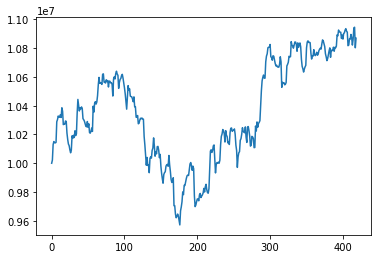

[10000000,
 10022293.842267282,
 10129690.12691041,
 10150676.440100279,
 10142951.943015832,
 10141409.968990201,
 10145079.836492056,
 10288560.44939859,
 10303843.43551797,
 10328384.984529717,
 10319964.513638139,
 10320321.980636349,
 10337675.481653834,
 10318345.362925777,
 10385821.179301096,
 10361511.717892494,
 10268621.363127809,
 10274775.733396864,
 10271641.4958985,
 10294037.386889458,
 10291128.340918107,
 10209851.885412395,
 10165810.867334375,
 10133515.882415013,
 10122453.873878011,
 10093789.787634807,
 10072612.142184949,
 10090801.444828821,
 10190889.804527266,
 10173121.876873052,
 10193946.475136869,
 10178991.637848005,
 10225679.068021059,
 10192256.298463246,
 10204882.394806739,
 10344878.917768914,
 10443833.048425432,
 10402545.83597613,
 10363630.064151037,
 10384988.645376494,
 10377771.34919198,
 10391573.938095389,
 10380265.633597802,
 10310152.407984719,
 10302720.231354654,
 10292156.499334516,
 10274053.26894715,
 10256478.452096716,
 10253453.

In [80]:
mwu(filename,'absolute','equal')

Final distribution:  [4.49475193e-04 9.92447477e-01 5.39207591e-04 1.35619146e-04
 4.54668445e-05 2.30313165e-03 1.02474704e-04 1.73838262e-04
 3.29349589e-05 5.45252243e-04 2.02458324e-04 5.13144948e-04
 2.35977833e-05 1.93704310e-03 3.23324529e-04 1.50083106e-05
 8.46877056e-05 1.25857608e-04]
Final transaction %:  49.40334128878281 total cost:  331180.9295755654
starting value:  10000000 final value:  11234612.632399494 less transaction costs:  10903431.702823928
Return 9.034317028239276 %


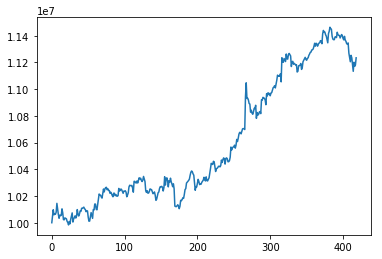

[10000000,
 10051299.737176929,
 10097069.646506708,
 10059197.7682572,
 10066727.351535445,
 10063099.449819136,
 10078482.129779644,
 10144983.84487362,
 10101998.484540109,
 10062343.383062914,
 10033282.578532167,
 10056965.079321545,
 10052948.776959032,
 10054771.721755972,
 10103858.645425577,
 10074701.615037408,
 10023516.428272014,
 10021572.067551248,
 10036495.223755635,
 10032315.698010823,
 10030124.687888304,
 10010867.903373655,
 10000963.49512299,
 9983520.547336338,
 10009170.0310649,
 9992000.73599815,
 10026079.643901993,
 10049210.715119306,
 10073506.507746138,
 10004852.927933387,
 10028473.697722258,
 10038142.160452731,
 10051518.236465156,
 10035093.319020918,
 10049008.331639655,
 10098338.216018483,
 10063958.452949718,
 10050366.476486111,
 10065434.304124432,
 10088543.07529544,
 10084711.088384533,
 10108241.940892952,
 10107363.381910218,
 10112559.323769355,
 10116644.183133444,
 10103517.088915145,
 10100217.252903791,
 10082512.08220023,
 10087086.752

In [81]:
mwu(filename,'absolute','marketcap')

Final distribution:  [0.10436494 0.04340811 0.0508658  0.06487054 0.03747823 0.07282948
 0.0361904  0.06383566 0.10669477 0.05622239 0.02852446 0.0283365
 0.09056911 0.05865398 0.08214742 0.01051102 0.02809699 0.03640019]
Final transaction %:  47.7326968973747 total cost:  755754.7045051038
starting value:  10000000 final value:  10701268.01515844 less transaction costs:  9945513.310653336
Return -0.5448668934666365 %


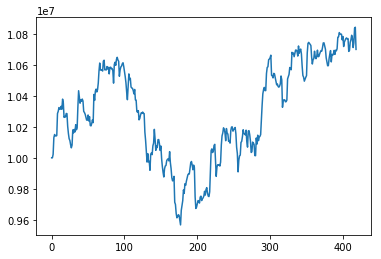

[10000000,
 10000000,
 10022293.842267282,
 10130445.348620696,
 10150834.59673441,
 10142411.057255372,
 10140914.73577049,
 10144081.160466824,
 10286507.603292592,
 10300963.049161436,
 10324961.252759974,
 10315542.463043466,
 10314736.377267674,
 10333139.679431066,
 10314195.913358714,
 10379679.797566444,
 10355482.36142515,
 10261628.931804892,
 10267483.192860516,
 10264098.591199316,
 10286964.089107815,
 10285555.746569939,
 10203301.482944794,
 10156981.054065665,
 10123543.171669059,
 10112072.570269207,
 10084921.258919602,
 10064656.498585958,
 10082254.73921,
 10180636.670837726,
 10161365.113069968,
 10183473.69508702,
 10167403.337933727,
 10214070.955533277,
 10181418.41256147,
 10193227.361898132,
 10329385.227221113,
 10434020.316375485,
 10393421.909184108,
 10353326.915810386,
 10374340.521463325,
 10366212.542849714,
 10380083.382506957,
 10367453.29081804,
 10300576.380498169,
 10293070.702014552,
 10282010.676480994,
 10262814.95814767,
 10244402.330182057,
 1

In [82]:
mwu(filename,'pricerel','equal')

Final distribution:  [8.57397198e-04 9.90397779e-01 7.40055869e-04 2.03747525e-04
 7.29716302e-05 2.91535667e-03 1.60981397e-04 3.47432491e-04
 4.30590157e-05 6.78568186e-04 2.50532906e-04 5.44317919e-04
 2.97661675e-05 2.14100264e-03 3.35591187e-04 2.13898665e-05
 9.00159907e-05 1.70034820e-04]
Final transaction %:  50.11933174224343 total cost:  281950.35912553687
starting value:  10000000 final value:  11182439.479141371 less transaction costs:  10900489.120015834
Return 9.004891200158335 %


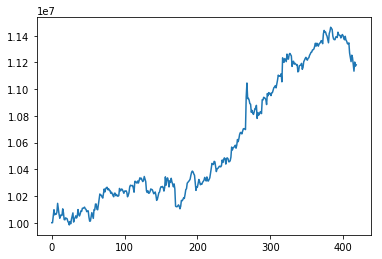

[10000000,
 10000000,
 10051299.737176929,
 10097073.587330423,
 10059203.961408567,
 10066726.5799817,
 10063096.753150165,
 10078483.754147528,
 10144982.014658246,
 10102030.387662867,
 10062375.182808487,
 10033307.70534213,
 10056985.257663598,
 10052971.88541848,
 10054794.418458184,
 10103877.787229236,
 10074717.248544032,
 10023525.524188988,
 10021579.70998388,
 10036497.791286495,
 10032328.291533131,
 10030137.86031513,
 10010852.45726012,
 10000951.920624252,
 9983506.299179332,
 10009146.944125919,
 9991974.18107984,
 10026047.241003398,
 10049178.514706045,
 10073493.246501053,
 10004867.632082047,
 10028487.889546597,
 10038139.478131749,
 10051536.755985841,
 10035087.017148832,
 10048993.895754183,
 10098383.104964161,
 10064118.952771965,
 10050520.220284346,
 10065530.873525372,
 10088628.96250115,
 10084790.431183552,
 10108323.555650538,
 10107459.70975849,
 10112596.829443539,
 10116665.982598282,
 10103544.593984835,
 10100224.45364153,
 10082504.317677109,
 100

In [83]:
mwu(filename,'pricerel','marketcap')

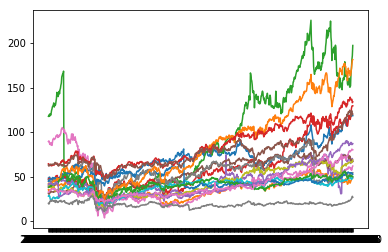

In [31]:
opening = pd.read_excel('lowvol_weekly.xlsx')[::-1].iloc[:,::2]
opening = opening.drop(['BRK.B_open'], axis=1)
plt.plot(opening)
plt.show()

In [82]:
d = (opening.iloc[-1] - opening.iloc[0])/opening.iloc[0]
d

WMT_open    1.457979
BK_open     0.377230
CI_open     0.676548
JPM_open    1.764831
DD_open     0.730868
CL_open     1.146506
HIG_open   -0.308501
AFL_open    0.180849
DOX_open    0.710112
BCE_open    0.731263
KO_open     0.182492
HON_open    3.316916
L_open      0.320655
PEP_open    1.083981
RSG_open    1.130382
PG_open     0.915419
SYY_open    1.458423
WU_open     0.341206
dtype: float64